<a href="https://colab.research.google.com/github/vibheshmodgil/vibhesh/blob/master/DrivecycleGenerationLatest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing the required Libraries **

In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import scipy.signal as signal
from sklearn.cluster import KMeans
import random
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from collections import Counter
import math
from scipy import interpolate
import seaborn as sns
from scipy.interpolate import RectBivariateSpline  # Importing RectBivariateSpline for 2D interpolation

In [ ]:
output_df = pd.read_excel('output.xlsx')

In [ ]:
# drive_cycle_1_df = pd.read_excel('Africa_visit_motor&Battery_loadpoints.xlsx', sheet_name='U703_Motor_load_Nairobi_Kambi_S',header=[0])
# drive_cycle_1_df.columns = drive_cycle_1_df.iloc[0]
# drive_cycle_1_df = drive_cycle_1_df.drop([0,1]).reset_index(drop=True)
# drive_cycle_1_df = drive_cycle_1_df.apply(pd.to_numeric, errors='coerce')
# time = drive_cycle_1_df['# Time']
# speed = drive_cycle_1_df['Veh Speed']

In [ ]:
# df_all = drive_cycle_1_df
# df_all['Filtered_speed'] = df_all['Veh Speed']*5/18
# df_all['Filtered_angle'] = df_all['Road slope']
# df_all['Filtered_speed']  = df_all['Filtered_speed'].rolling(window=3,center = True).mean()
# df_all['Filtered_speed'] = df_all['Filtered_speed'].round(2)

**Filtering the speed for smoother opreatins**

In [ ]:
# Apply the Butterworth filter to the Speed column
df_all = output_df
df_all = df_all[df_all['Speed'] > 0]


df_all['Filtered_angle'] = df_all['angle']
df_all['Filtered_speed']  = df_all['Speed'].rolling(window=3,center = True).mean()
df_all['Filtered_speed'] = df_all['Filtered_speed'].round(2)

<ipython-input-11-cb8b9cd25334>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['Filtered_angle'] = df_all['angle']
<ipython-input-11-cb8b9cd25334>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['Filtered_speed']  = df_all['Speed'].rolling(window=3,center = True).mean()
<ipython-input-11-cb8b9cd25334>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

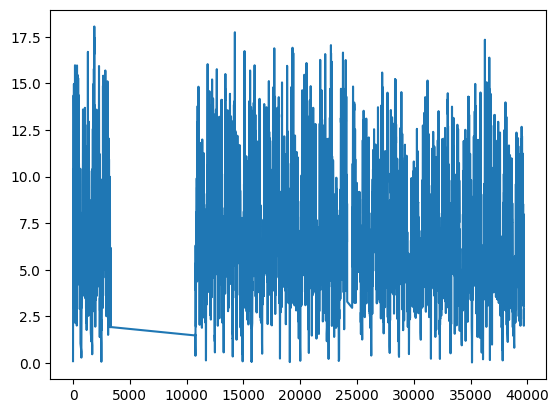

In [ ]:
plt.plot(df_all['Filtered_speed'])

In [ ]:
# prompt: filter the angle same as speed

df_all['Filtered_angle'] = df_all['Filtered_angle'].rolling(window=3,center = True).mean()
df_all['Filtered_angle'] = df_all['Filtered_angle'].round(2)


<ipython-input-13-63535289c839>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['Filtered_angle'] = df_all['Filtered_angle'].rolling(window=3,center = True).mean()
<ipython-input-13-63535289c839>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['Filtered_angle'] = df_all['Filtered_angle'].round(2)


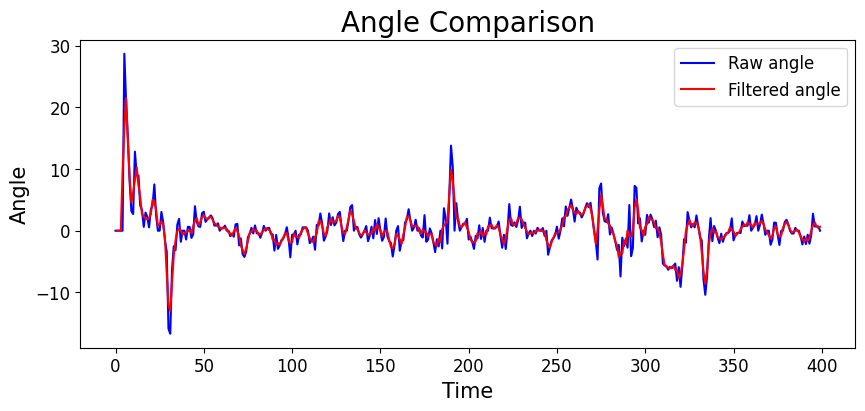

In [ ]:
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 4))

# Plot the two series
ax.plot(df_all['angle'][:400], label="Raw angle", color='blue')
ax.plot(df_all['Filtered_angle'][:400], label="Filtered angle", color='red')

# Add a title and axis labels
ax.set_title("Angle Comparison", fontsize=20)
ax.set_xlabel("Time", fontsize=15)
ax.set_ylabel("Angle", fontsize=15)

# Add a legend
ax.legend(fontsize=12, loc='upper right')

# Adjust the font size of tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.show()

In [ ]:
df_all['acceleration'] = df_all['Filtered_speed'].diff()
df_all = df_all.dropna() # droping all the nan values
df_all = df_all.reset_index(drop = True) #The index should be reindexed after deleting the nan values

<ipython-input-15-966fcfc15801>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all['acceleration'] = df_all['Filtered_speed'].diff()


**K-means clustering to make the speed segments**

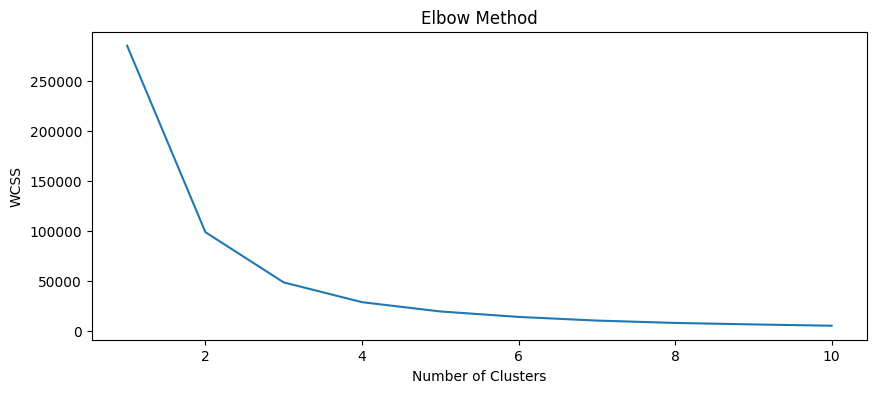

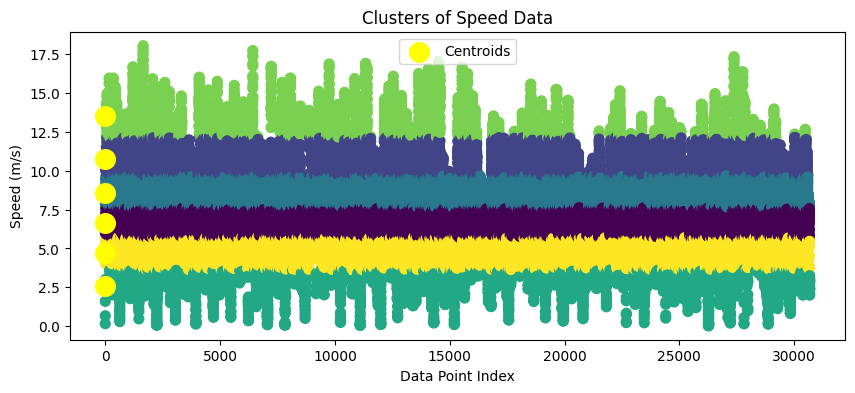

In [ ]:
# Reshape the speed data to a 2D array
X = np.array(df_all['Filtered_speed']).reshape(-1, 1)

# Determine the optimal number of clusters using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(10, 4))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()
x_indices = range(len(X))
# Train the K-means model
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X)

# Get the speed ranges for each cluster
speed_ranges = []
for i in range(6):
    cluster_indices = np.where(y_kmeans == i)[0]
    min_speed = X[cluster_indices].min()
    max_speed = X[cluster_indices].max()
    speed_ranges.append((min_speed, max_speed))

# Create a bigger plot with all the clusters
fig, ax = plt.subplots(figsize=(10,4))
ax.scatter(x_indices, X, c=y_kmeans, s=50)
ax.scatter(range(len(kmeans.cluster_centers_)), kmeans.cluster_centers_[:, 0], s=200, c='yellow', label='Centroids')
ax.set_title('Clusters of Speed Data')
ax.set_xlabel('Data Point Index')
ax.set_ylabel('Speed (m/s)')
ax.legend()
plt.show()




**Based on optimal parameters based on optimzation mopdes we are creating here**

In [ ]:

res = [0.4, 0.2, 3, 0.447]

a1 = res[0]
a2 = res[1]
n = res[2]
delta = res[3]

df_all['mode'] = "None"

# Create a new column called 'check_acc' that is True if the acceleration is greater than or equal to a2

df_all['check_acc'] = (df_all['acceleration'] >= a2)

# Initialize empty dictionaries to store information about acceleration and deacceleration snippets
dic_acc = {}
dic_dacc = {}

# Extract the check_acc and speed columns as lists
check_acc = df_all['check_acc'].tolist()[1:]
speed = df_all['Filtered_speed'].tolist()[1:]

# Initialize a counter variable
d = 0

# Iterate through each row of the check_acc and speed lists
for i in range(len(check_acc)):

    # If the current row indicates that acceleration is >= a2, increment the counter
    if check_acc[i]:
        d += 1

    # If the current row indicates that acceleration is < a2, and the previous n rows had acceleration >= a2,
    # and the speed has increased by more than delta over those n rows, add the acceleration snippet to dic_acc
    elif d > n and speed[i] - speed[i-d] > delta:
        dic_acc[i-d+1] = d
        d = 0

    # If the above conditions are not met, reset the counter
    else:
        d = 0

# Initialize the 'mode' column to None for all rows
print(dic_acc)

# For each acceleration snippet in dic_acc, set the 'mode' column to 'Acceleration'
ji = 0
for key, value in dic_acc.items():
    df_all.iloc[key:key+value, 3] = 'Acceleration'
    ji+=1

# For rows where acceleration is greater than a1, set the 'mode' column to 'Acceleration'
df_all.loc[df_all['acceleration'] > a1, 'mode'] = 'Acceleration'

# Repeat the above process for deacceleration
df_all['check_dacc'] = (df_all['acceleration'] <= -a2)
check_dacc = df_all['check_dacc'].tolist()[1:]
d = 0
for i in range(len(check_dacc)):
    if check_dacc[i]:
        d += 1
    elif d > n and speed[i-d] - speed[i] > delta:
        dic_dacc[i-d+1] = d
        d = 0
    else:
        d = 0

for key, value in dic_dacc.items():
    df_all.iloc[key:key+value, 3] = 'Deacceleration'
df_all.loc[df_all['acceleration'] < -a1, 'mode'] = 'Deacceleration'


# Set mode to 'cruise' for rows where acceleration is positive and mode is None
df_all.loc[(df_all['acceleration'] > 0) & (df_all['mode']=='None'), 'mode'] = 'cruise'


# Set mode to 'idle' for rows where acceleration is negative and mode is None
df_all.loc[(df_all['acceleration'] <= 0) & (df_all['mode']=='None'), 'mode'] = 'idle'

# Removing the columns that are not needed
df_all.drop(['check_acc', 'check_dacc'], axis=1, inplace=True)

{1: 10, 12: 5, 30: 11, 45: 8, 71: 9, 101: 4, 112: 7, 130: 7, 142: 5, 152: 4, 160: 14, 188: 14, 209: 5, 221: 11, 262: 4, 273: 7, 293: 7, 311: 5, 321: 4, 333: 12, 376: 6, 405: 7, 441: 10, 472: 4, 484: 9, 515: 9, 538: 5, 551: 4, 569: 5, 591: 4, 601: 4, 633: 6, 687: 8, 713: 4, 729: 4, 737: 6, 751: 8, 785: 8, 802: 4, 813: 6, 825: 6, 847: 5, 860: 5, 880: 9, 914: 10, 935: 5, 950: 6, 957: 4, 981: 4, 991: 5, 1019: 5, 1040: 6, 1063: 8, 1081: 5, 1098: 11, 1149: 4, 1183: 15, 1201: 5, 1223: 11, 1250: 13, 1273: 8, 1307: 8, 1331: 5, 1344: 4, 1361: 4, 1394: 5, 1420: 7, 1465: 4, 1483: 4, 1495: 7, 1512: 9, 1530: 9, 1551: 13, 1582: 6, 1596: 8, 1607: 4, 1624: 19, 1665: 10, 1694: 7, 1736: 8, 1780: 4, 1790: 8, 1831: 9, 1865: 5, 1880: 4, 1892: 7, 1916: 8, 1949: 5, 1961: 4, 1973: 5, 1982: 5, 1997: 7, 2011: 4, 2036: 6, 2043: 7, 2057: 5, 2083: 4, 2089: 4, 2148: 9, 2189: 4, 2199: 5, 2211: 4, 2254: 7, 2324: 6, 2335: 5, 2348: 5, 2368: 14, 2384: 5, 2398: 10, 2451: 8, 2475: 7, 2489: 5, 2510: 8, 2522: 6, 2542: 10, 25

<ipython-input-17-8bdf3e45d8a6>:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Acceleration' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_all.iloc[key:key+value, 3] = 'Acceleration'


In [ ]:
meanSpeed = df_all['Filtered_speed'].mean()
stdspeed = df_all['Filtered_speed'].std()
meanAcceleration = df_all['acceleration'].mean()
stdAcceleration = df_all['acceleration'].std()
countMode = df_all['mode'].value_counts()
accTime = (countMode["Acceleration"]/len(df_all))*100
daccTime = (countMode["Deacceleration"]/len(df_all))*100
idleTime = (countMode["idle"]/len(df_all))*100
cruiseTime = (countMode["cruise"]/len(df_all))*100

data_dict = {
    "meanSpeed": meanSpeed,
    "stdspeed": stdspeed,
    "meanAcceleration": meanAcceleration,
    "stdAcceleration": stdAcceleration,
    "countMode": countMode,
    "accTime": accTime,
    "daccTime": daccTime,
    "idleTime": idleTime,
    "cruiseTime": cruiseTime
}
for i in data_dict:
    print(i, data_dict[i])

meanSpeed 7.550182517436934
stdspeed 3.0511792122892034
meanAcceleration 7.56143667296787e-05
stdAcceleration 0.5231210422099255
countMode mode
idle              10534
cruise             8617
Acceleration       6374
Deacceleration     5157
Name: count, dtype: int64
accTime 20.774395410990156
daccTime 16.80790039762727
idleTime 34.33283358320839
cruiseTime 28.08487060817417


**Creating the snippit out of the data**

In [ ]:
# This res will have the snippit information with starting index ending index and the mode in which
# it is working

mode = df_all['mode'].tolist()
# print(mode)s
currMode = None
l = 0
r = 0
snippit = []
while r < len(mode):
    currMode = mode[l]
    r += 1
    while r < len(mode) and mode[r] == currMode :
        r += 1

    snippit.append([(l,r-1),currMode])
    l = r

print(snippit[:20],'..............')

[[(0, 0), 'cruise'], [(1, 10), 'Acceleration'], [(11, 13), 'cruise'], [(14, 15), 'Acceleration'], [(16, 16), 'cruise'], [(17, 17), 'idle'], [(18, 21), 'Deacceleration'], [(22, 24), 'Acceleration'], [(25, 25), 'idle'], [(26, 28), 'Deacceleration'], [(29, 29), 'cruise'], [(30, 32), 'Acceleration'], [(33, 34), 'cruise'], [(35, 40), 'Acceleration'], [(41, 41), 'idle'], [(42, 43), 'Deacceleration'], [(44, 44), 'idle'], [(45, 52), 'Acceleration'], [(53, 54), 'idle'], [(55, 56), 'cruise']] ..............


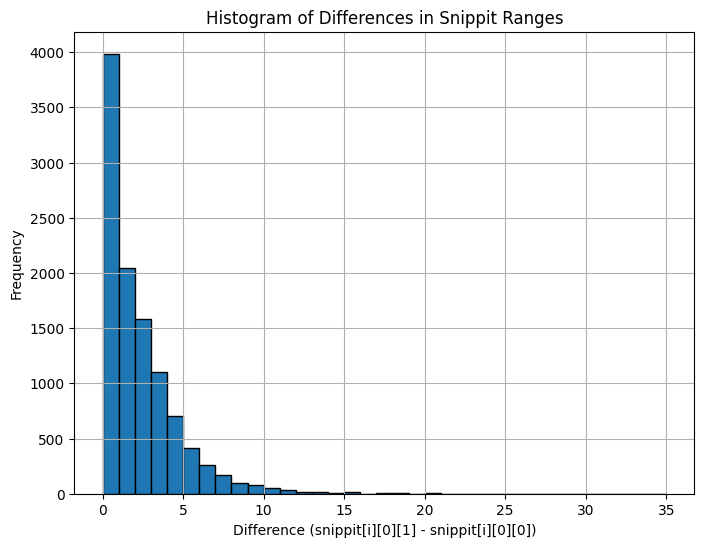

In [ ]:
def plot_histogram(snippit):
    # Calculate the differences between the pairs in snippit
    differences = [entry[0][1] - entry[0][0] for entry in snippit]

    # Plotting the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(differences, bins=range(min(differences), max(differences) + 2), edgecolor='black')
    plt.title('Histogram of Differences in Snippit Ranges')
    plt.xlabel('Difference (snippit[i][0][1] - snippit[i][0][0])')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Example usage
plot_histogram(snippit)

In [ ]:
print(speed_ranges)

[(5.71, 7.62), (9.69, 12.14), (7.63, 9.68), (0.03, 3.64), (12.15, 18.05), (3.65, 5.7)]


**Creating the tranistions dictionary for the particular speed ranges**

In [ ]:
transition_mode_speed = {}
for interval in speed_ranges :
    starting_speed = interval[0]
    ending_speed = interval[1]
    transition_mode_speed[(starting_speed,ending_speed)] = []
    for i in range(len(snippit)-1):

        snip = snippit[i]
        ev = df_all['Filtered_speed'][snip[0][1]]

        if ev>=starting_speed and ev<ending_speed:
            transition_mode_speed[(starting_speed,ending_speed)].append((snip[1],snippit[i+1][1]))
transition_mode_speed

{(5.71, 7.62): [('idle', 'Deacceleration'),
  ('cruise', 'Acceleration'),
  ('Deacceleration', 'idle'),
  ('idle', 'Acceleration'),
  ('Deacceleration', 'idle'),
  ('idle', 'Acceleration'),
  ('Deacceleration', 'idle'),
  ('idle', 'cruise'),
  ('cruise', 'Acceleration'),
  ('Deacceleration', 'idle'),
  ('idle', 'Acceleration'),
  ('Deacceleration', 'cruise'),
  ('cruise', 'Acceleration'),
  ('Deacceleration', 'idle'),
  ('idle', 'cruise'),
  ('cruise', 'Acceleration'),
  ('idle', 'cruise'),
  ('Deacceleration', 'idle'),
  ('idle', 'cruise'),
  ('cruise', 'Acceleration'),
  ('idle', 'cruise'),
  ('Deacceleration', 'idle'),
  ('idle', 'Acceleration'),
  ('Deacceleration', 'Acceleration'),
  ('Deacceleration', 'idle'),
  ('idle', 'cruise'),
  ('cruise', 'Acceleration'),
  ('cruise', 'Acceleration'),
  ('Acceleration', 'cruise'),
  ('cruise', 'idle'),
  ('idle', 'Deacceleration'),
  ('idle', 'Deacceleration'),
  ('Acceleration', 'cruise'),
  ('cruise', 'idle'),
  ('idle', 'cruise'),
  ('cr

**Creating Transition Probability Matrix**

In [ ]:
transition_probability_matrix = {}
dic_modes = {'Acceleration':0, 'Deacceleration':1, 'cruise':2, 'idle':3}
modes = ['Acceleration', 'Deacceleration', 'cruise', 'idle']

for t in transition_mode_speed:

    # Initialize the transition probability matrix
    n_modes = len(modes)
    P = np.zeros((n_modes, n_modes))
    only_modes = transition_mode_speed[t]

    # Count the number of transitions between modes
    for i in range(len(only_modes)):
        row = dic_modes[only_modes[i][0]]
        col = dic_modes[only_modes[i][1]]
        P[row, col] += 1

    # Normalize the counts to get probabilities
    for i in range(n_modes):
        row_sum = np.sum(P[i, :])
        if row_sum > 0:
            P[i, :] /= row_sum
    transition_probability_matrix[t] = P

In [ ]:
transition_probability_matrix

{(5.71,
  7.62): array([[0.        , 0.00253807, 0.89340102, 0.10406091],
        [0.01459854, 0.        , 0.16788321, 0.81751825],
        [0.49240781, 0.03687636, 0.        , 0.47071584],
        [0.09195402, 0.34712644, 0.56091954, 0.        ]]),
 (9.69,
  12.14): array([[0.        , 0.00258398, 0.89147287, 0.10594315],
        [0.        , 0.        , 0.00862069, 0.99137931],
        [0.22146508, 0.0306644 , 0.        , 0.74787053],
        [0.00404858, 0.59919028, 0.39676113, 0.        ]]),
 (7.63,
  9.68): array([[0.        , 0.00590551, 0.88779528, 0.10629921],
        [0.        , 0.        , 0.07096774, 0.92903226],
        [0.28232503, 0.02965599, 0.        , 0.68801898],
        [0.01749664, 0.56393001, 0.41857335, 0.        ]]),
 (0.03,
  3.64): array([[0.        , 0.        , 0.91666667, 0.08333333],
        [0.03833866, 0.        , 0.27795527, 0.68370607],
        [0.67732558, 0.        , 0.        , 0.32267442],
        [0.12121212, 0.10722611, 0.77156177, 0.        ]]),

In [ ]:
final = {}
modes = ['Acceleration', 'Deacceleration', 'cruise', 'idle']
for i in set(modes):
    final[i] = {}
filtered_speed = df_all['Filtered_speed']

for snip in snippit:
    mode_of_snnipit = snip[1]
    start_index = snip[0][0]
    end_index = snip[0][1]
    starting_speed = filtered_speed[start_index]
    ending_speed = filtered_speed[end_index]

    if starting_speed not in final[mode_of_snnipit]:
        final[mode_of_snnipit][starting_speed] = []

    final[mode_of_snnipit][starting_speed].append([(start_index,end_index),ending_speed])

Creating the map for the modes based on the maxn value in the transition probability matrix

In [ ]:
# @title Default title text
def driveCycle(tol):
    """

    Args:
      tol:

    Returns:

    """
    drivecycle = [] # This will store the drive cycle information
    elevation = []
    mode = []


    current_mode = 'idle' # Selecting the first mode for the first snippit
    contender_snippit = final[current_mode][0.1] # Chooosing the starting snnipit from the idle mode that had the starting speed zero
    randomly_choosen_snnipit = random.choice(contender_snippit) # Randomly choose the starting snnipit

    # Adding the speed valuesof the snnipit to the drivecycle choosen
    for i in range(randomly_choosen_snnipit[0][0],randomly_choosen_snnipit[0][1]+1):
        drivecycle.append(df_all['Filtered_speed'][i])
        elevation.append(df_all['angle'][i])
        mode.append(current_mode)
    ending_speed_of_snnipit = randomly_choosen_snnipit[1]
    # Now we have to check the ending speed of the snnipit lies within what class of the speed
    for tup in speed_ranges:
        if ending_speed_of_snnipit >= tup[0] and ending_speed_of_snnipit < tup[1]:
            speed_class = tup
    # Now according to the speed class we will select the next mode of opreation
    next_mode = np.random.choice(['Acceleration', 'Deacceleration', 'cruise', 'idle'], p=transition_probability_matrix[(speed_class)][dic_modes[current_mode]])

    for x in range(400):
        tolerance = tol
        min_allowed_speed = ending_speed_of_snnipit-tolerance
        max_allowed_speed = ending_speed_of_snnipit+tolerance
        contender_snippit = []
        for s in final[next_mode]:
            if s>min_allowed_speed and s<max_allowed_speed:
                contender_snippit.extend(final[next_mode][round(s, 2)])

        randomly_choosen_snnipit = random.choice(contender_snippit) # Randomly choose the starting snnipit


        # Adding the speed valuesof the snnipit to the drivecycle choosen
        for i in range(randomly_choosen_snnipit[0][0],randomly_choosen_snnipit[0][1]+1):
            drivecycle.append(df_all['Filtered_speed'][i])
            elevation.append(df_all['angle'][i])
            mode.append(next_mode)
        ending_speed_of_snnipit = randomly_choosen_snnipit[1]

        # Now we have to check the ending speed of the snnipit lies within what class of the speed
        for tup in speed_ranges:
            if ending_speed_of_snnipit >= tup[0] and ending_speed_of_snnipit < tup[1]:
                speed_class = tup
        ## Here we have to think how to integrate np.random.choice()
        next_mode = np.random.choice(['Acceleration', 'Deacceleration', 'cruise', 'idle'], p=transition_probability_matrix[(speed_class)][dic_modes[next_mode]])

        # transition_probability_matrix[speed_interval][i].argmax()
        # # Generate 10 random choices based on the predefined probability matrix


        if (len(drivecycle) >= 1500) and (ending_speed_of_snnipit <= 1 ) :
            break

#         final[next_mode] = [lst for lst in final[next_mode] if not np.array_equal(lst, randomly_choosen_snnipit)]
    # plot the drive cycle
# increase figure size
    # fig, ax = plt.subplots(figsize=(10, 4))

    # # plot the data
    # ax.plot(drivecycle, color='blue', label='Drive Cycle')

    # # add labels and title
    # ax.set_xlabel('Time (s)', fontsize=14)
    # ax.set_ylabel('Speed (m/s)', fontsize=14)
    # ax.set_title('Drive Cycle', fontsize=16)

    # # customize the appearance of the plot
    # ax.grid(color='lightgray', linestyle='--', linewidth=0.5)
    # max_speed = int(max(drivecycle)) + 10
    # ax.set_ylim(0, max_speed)
    # ax.set_xticks(range(0, len(drivecycle) + 1, 200))
    # ax.set_yticks(range(0, max_speed + 1, 10))

    # # add legend
    # ax.legend(fontsize=12)

    # # show the plot
    # plt.show()
    return drivecycle , elevation,mode

    # set the path where you want to save the image


In [ ]:
candidateDriveCycles = []
elevationDriveCycles = []
modeDriveCycles = []
tolerance_limits = list(np.arange(0, 0.11, 0.01))
for tol in tolerance_limits :
    for i in range(100):
        try :
            drivecycle , elevation,mode = driveCycle(tol)
            candidateDriveCycles.append(drivecycle)
            elevationDriveCycles.append(elevation)
            modeDriveCycles.append(mode)
        except :
            pass

In [ ]:
candidateDriveCycles

[[0.1,
  0.09,
  0.08,
  0.08,
  0.09,
  0.13,
  0.18,
  0.29,
  0.47,
  0.69,
  0.94,
  1.19,
  1.44,
  1.7,
  1.94,
  2.14,
  2.26,
  2.31,
  2.3,
  3.99,
  5.58,
  5.6,
  5.57,
  5.55,
  5.56,
  5.76,
  5.78,
  5.67,
  5.67,
  5.91,
  6.17,
  6.37,
  6.39,
  6.28,
  6.18,
  6.11,
  6.05,
  6.0,
  5.94,
  5.88,
  5.82,
  5.77,
  5.73,
  5.68,
  5.62,
  5.56,
  5.5,
  5.47,
  5.46,
  5.61,
  5.95,
  6.18,
  6.22,
  6.19,
  7.21,
  8.74,
  9.93,
  10.57,
  10.55,
  10.55,
  10.32,
  10.04,
  9.75,
  9.51,
  9.44,
  9.45,
  9.93,
  10.39,
  10.37,
  10.35,
  10.2,
  9.93,
  9.58,
  9.6,
  9.12,
  8.53,
  8.54,
  8.43,
  8.29,
  8.09,
  8.07,
  8.09,
  7.83,
  7.83,
  7.2,
  6.78,
  6.81,
  6.61,
  6.4,
  6.22,
  6.01,
  5.69,
  5.47,
  5.32,
  5.21,
  5.19,
  5.12,
  5.13,
  5.12,
  5.1,
  5.31,
  5.32,
  5.23,
  5.09,
  4.92,
  4.75,
  4.58,
  4.41,
  4.23,
  4.07,
  3.95,
  3.91,
  3.9,
  3.9,
  4.21,
  4.2,
  5.38,
  6.6,
  7.35,
  7.36,
  7.61,
  7.61,
  8.41,
  9.1,
  9.09,
  9.17,

In [ ]:
def SAFDdiff(observed_data,candidate_cycle,mode_cycle) :


    # Define the speed and acceleration resolutions
    speed_resolution = 1  # mph
    acceleration_resolution = 0.05  # mph/s

    # Compute the fraction of time spent at each speed-acceleration pair in the candidate cycle
    counts_candidate = np.zeros((121, 121))
    for i in range(len(candidate_cycle) - 1):
        a = ((candidate_cycle[i+1] - candidate_cycle[i]) / acceleration_resolution)
        v = candidate_cycle[i+1] / speed_resolution
        a_clamped = min(max(int(a), 0), 120)
        v_clamped = min(max(int(v), 0), 120)
        # Update counts_candidate
        counts_candidate[a_clamped, v_clamped] += 1
    fractions_candidate = counts_candidate / len(candidate_cycle)
    # print(fractions_candidate)
    # Compute the fraction of time spent at each speed-acceleration pair in the observed data
    counts_observed = np.zeros((121, 121))
    for i in range(len(observed_data) - 1):
        a = df_all['acceleration'][i] / acceleration_resolution
        v = observed_data['Filtered_speed'][i+1] / speed_resolution
        counts_observed[int(a), int(v)] += 1
    fractions_observed = counts_observed / len(observed_data)
    # print(fractions_observed[:][10])

    # print(fractions_observed)
    # Compute the SAFDdiff
    SAFDdiff = np.sum(np.abs(fractions_candidate - fractions_observed))
    # print("final: ",final)
    return SAFDdiff

In [ ]:
SAFDiff_val = []
for i in range(len(candidateDriveCycles)) :
    out = SAFDdiff(df_all,candidateDriveCycles[i],modeDriveCycles[i])
    SAFDiff_val.append(out)


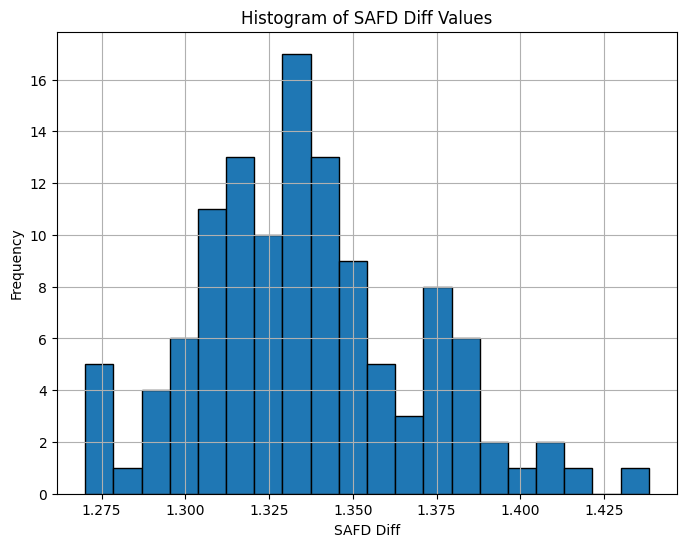

In [ ]:


plt.figure(figsize=(8, 6))
plt.hist(SAFDiff_val, bins=20, edgecolor='black')
plt.title('Histogram of SAFD Diff Values')
plt.xlabel('SAFD Diff')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
import heapq

# Find the indices of the five smallest values in SAFDiff_val
smallest_indices = heapq.nsmallest(5, range(len(SAFDiff_val)), key=SAFDiff_val.__getitem__)

print(smallest_indices)


[117, 113, 109, 78, 38]


In [ ]:
print("Average Speed:", df_all['Filtered_speed'].mean())
print("Standard deviation of Speed:", df_all['Filtered_speed'].std())
print("Max Speed:", df_all['Filtered_speed'].max())
print("Min Speed:", df_all['Filtered_speed'].min())

print("Average Acceleration:", np.average(df_all['acceleration']))
print("Standard deviation of Acceleration:", df_all['acceleration'].std())
print("Max Acceleration:", df_all['acceleration'].max())
print("Min Acceleration:", df_all['acceleration'].min())



Average Speed: 7.550182517436934
Standard deviation of Speed: 3.0511792122892034
Max Speed: 18.05
Min Speed: 0.03
Average Acceleration: 7.56143667296787e-05
Standard deviation of Acceleration: 0.5231210422099255
Max Acceleration: 1.790000000000001
Min Acceleration: -3.1400000000000006


1.2701060560273876
Average Speed : 7.341867612293144
Standard Deviation of Speed: 2.8629432459891375
Max Speed: 15.11
Min Speed: 0.07
Average Acceleration: 0.0025788643533123023
Standard Deviation of Acceleration: 0.5220499715568384
Max Acceleration: 1.42
Min Acceleration: -2.42


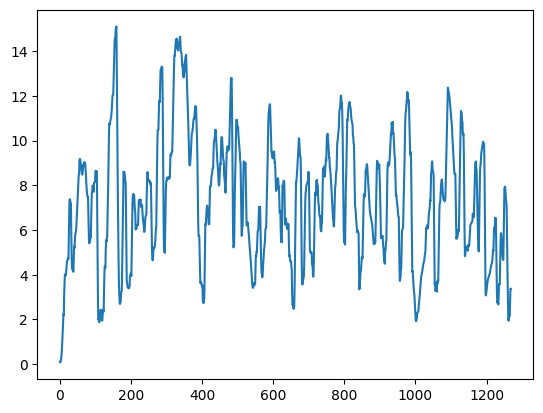

1.2731634766336366
Average Speed : 7.596623270951993
Standard Deviation of Speed: 2.9100074637422075
Max Speed: 14.71
Min Speed: 0.08
Average Acceleration: 0.00698697068403909
Standard Deviation of Acceleration: 0.48612629204478086
Max Acceleration: 1.4900000000000002
Min Acceleration: -2.34


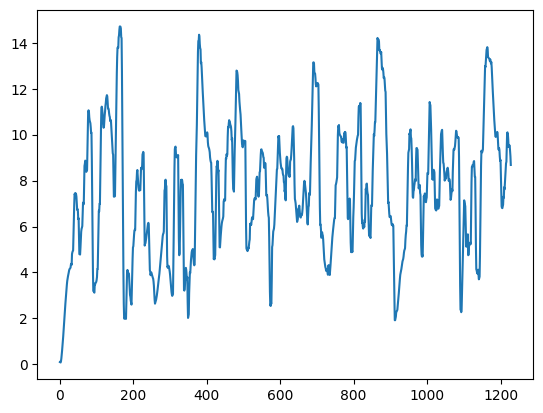

1.2732530697850963
Average Speed : 7.134276475343572
Standard Deviation of Speed: 2.6941246409170887
Max Speed: 14.85
Min Speed: 0.08
Average Acceleration: 0.005938511326860843
Standard Deviation of Acceleration: 0.4900264269728362
Max Acceleration: 1.5399999999999991
Min Acceleration: -2.45


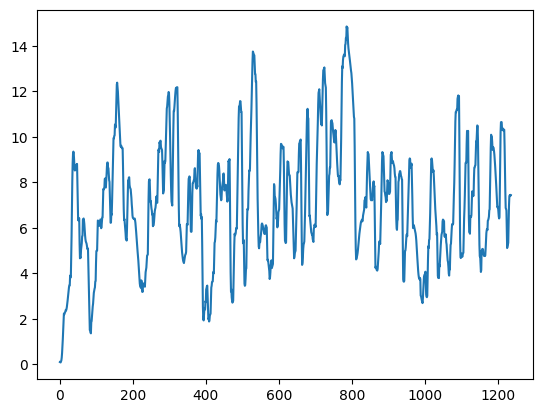

1.2734947398492855
Average Speed : 7.2856080557707195
Standard Deviation of Speed: 3.2383585457777504
Max Speed: 15.25
Min Speed: 0.07
Average Acceleration: 0.005984496124031006
Standard Deviation of Acceleration: 0.4851391550469101
Max Acceleration: 1.3899999999999997
Min Acceleration: -2.289999999999999


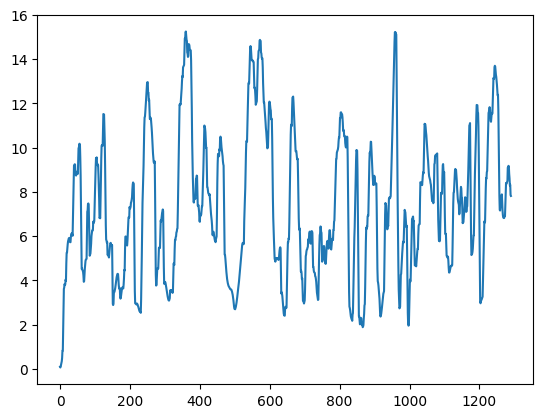

1.2776933816985023
Average Speed : 7.316233254531126
Standard Deviation of Speed: 2.8270718456756674
Max Speed: 14.7
Min Speed: 0.08
Average Acceleration: 0.004077287066246057
Standard Deviation of Acceleration: 0.5165178700829599
Max Acceleration: 1.6500000000000004
Min Acceleration: -2.3899999999999997


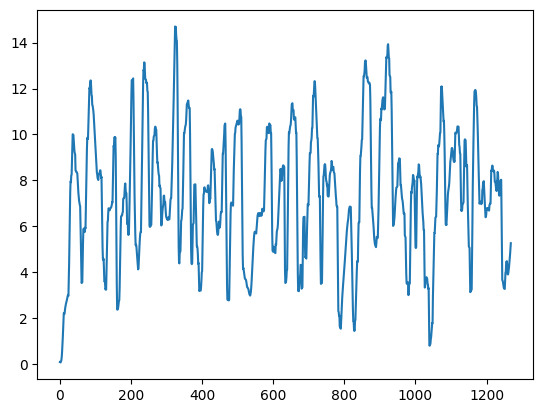

In [ ]:
for i in smallest_indices:
    print(SAFDiff_val[i])

    # Average and standard deviation of speed
    avg_speed = np.average(candidateDriveCycles[i])
    std_speed = np.std(candidateDriveCycles[i])
    print(f"Average Speed : {avg_speed}")
    print(f"Standard Deviation of Speed: {std_speed}")

    # Max and min speed
    max_speed = np.max(candidateDriveCycles[i])
    min_speed = np.min(candidateDriveCycles[i])
    print(f"Max Speed: {max_speed}")
    print(f"Min Speed: {min_speed}")

    # Acceleration calculations
    drive_cycle_acceleration = np.diff(candidateDriveCycles[i])
    avg_acceleration = np.mean(drive_cycle_acceleration)
    std_acceleration = np.std(drive_cycle_acceleration)
    print(f"Average Acceleration: {avg_acceleration}")
    print(f"Standard Deviation of Acceleration: {std_acceleration}")

    # Max and min acceleration
    max_acceleration = np.max(drive_cycle_acceleration)
    min_acceleration = np.min(drive_cycle_acceleration)
    print(f"Max Acceleration: {max_acceleration}")
    print(f"Min Acceleration: {min_acceleration}")

    # Plot the drive cycle
    plt.plot(candidateDriveCycles[i])
    plt.show()


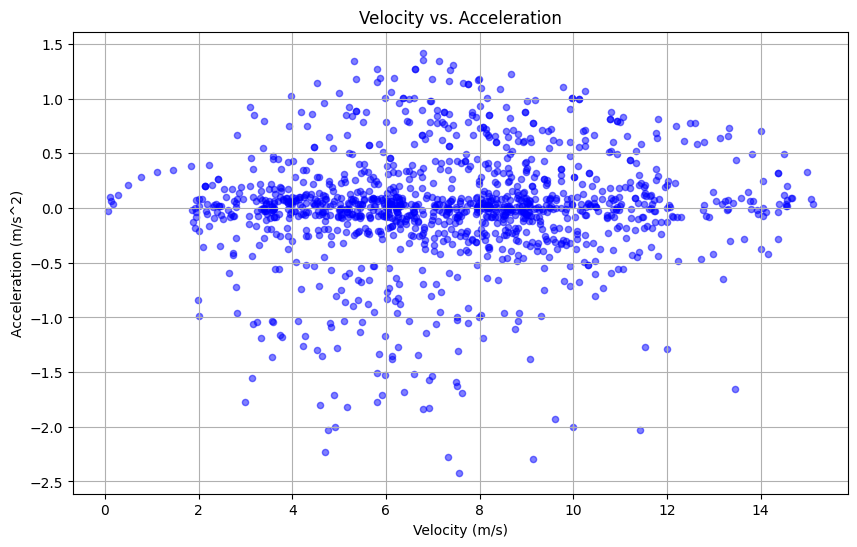

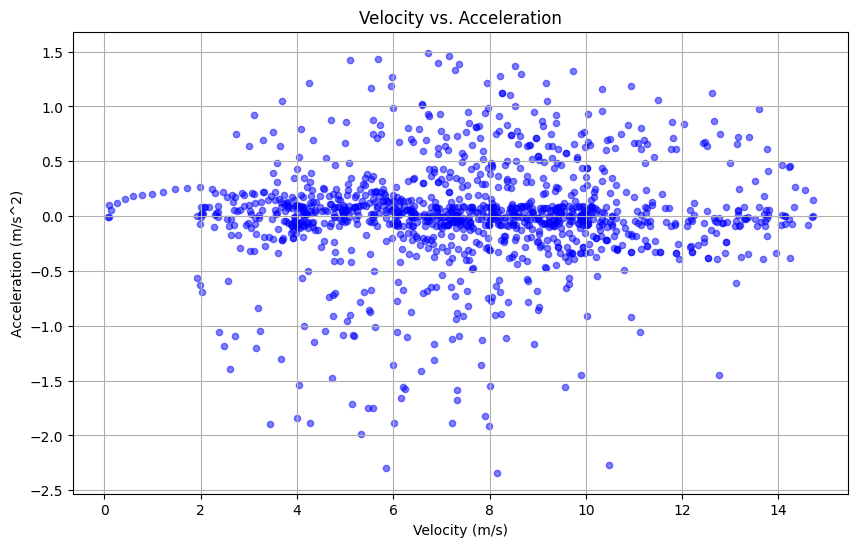

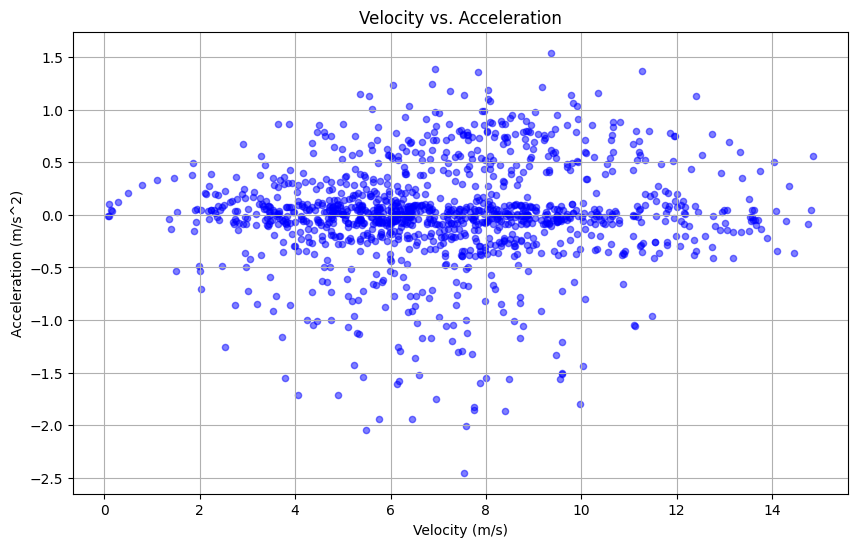

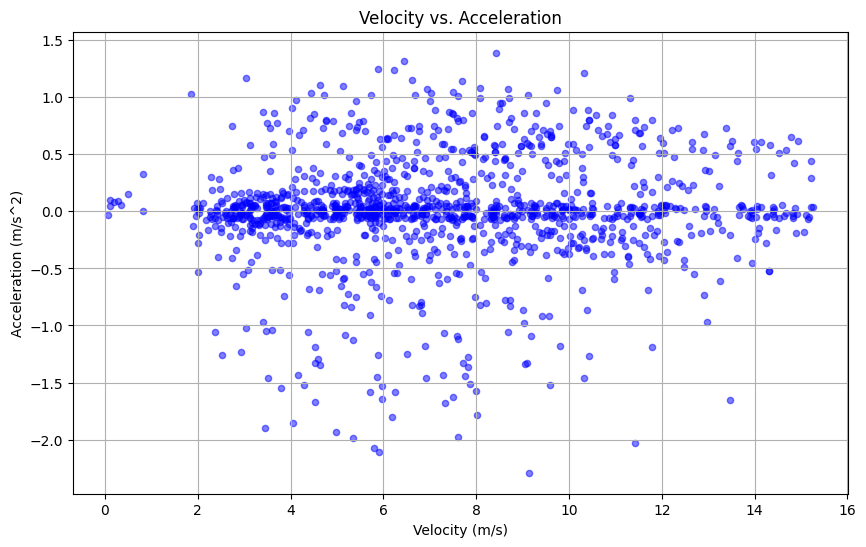

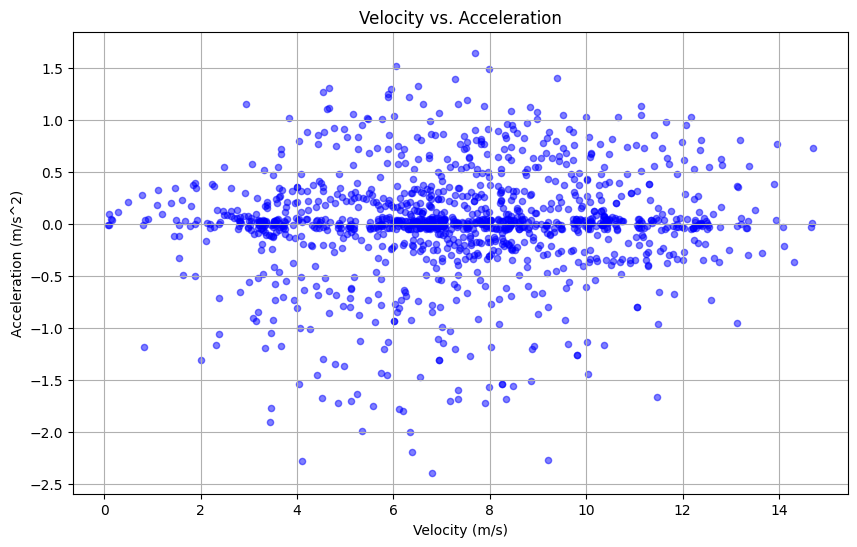

In [ ]:
for i in smallest_indices :
    # prompt: This is the list of velocity data per second plot the scatter plot of velocity vs acceleration out of it

    # Calculate acceleration (approximate using finite differences)
    acceleration = np.diff(candidateDriveCycles[i], prepend=0)

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(candidateDriveCycles[i], acceleration, s=20, c='blue', alpha=0.5)
    plt.xlabel('Velocity (m/s)')
    plt.ylabel('Acceleration (m/s^2)')
    plt.title('Velocity vs. Acceleration')
    plt.grid(True)
    plt.show()


In [ ]:
# prompt: candidateDriveCycles[i] this has velocity data calulate avg and standard deviation of acceleration

for i in smallest_indices:
    drive_cycle_acceleration = np.diff(candidateDriveCycles[i])
    avg_acceleration = np.mean(drive_cycle_acceleration)
    std_acceleration = np.std(drive_cycle_acceleration)
    print(f"Drive Cycle {i}:")
    print(f"  Average Acceleration: {avg_acceleration}")
    print(f"  Standard Deviation of Acceleration: {std_acceleration}")


Drive Cycle 117:
  Average Acceleration: 0.0025788643533123023
  Standard Deviation of Acceleration: 0.5220499715568384
Drive Cycle 113:
  Average Acceleration: 0.00698697068403909
  Standard Deviation of Acceleration: 0.48612629204478086
Drive Cycle 109:
  Average Acceleration: 0.005938511326860843
  Standard Deviation of Acceleration: 0.4900264269728362
Drive Cycle 78:
  Average Acceleration: 0.005984496124031006
  Standard Deviation of Acceleration: 0.4851391550469101
Drive Cycle 38:
  Average Acceleration: 0.004077287066246057
  Standard Deviation of Acceleration: 0.5165178700829599


In [ ]:
df = pd.DataFrame({'Speed': candidateDriveCycles[15]})

# convert the 'Speed [km/h]' column to km/s
df['Speed [km/h]'] = df['Speed']*18/5

# add a column with time values
df['Time [s]'] = pd.Series(range(len(candidateDriveCycles[15])))

print(df)

      Speed  Speed [km/h]  Time [s]
0      0.10         0.360         0
1      0.07         0.252         1
2      0.08         0.288         2
3      0.09         0.324         3
4      0.13         0.468         4
...     ...           ...       ...
1244   6.21        22.356      1244
1245   6.19        22.284      1245
1246   6.20        22.320      1246
1247   6.24        22.464      1247
1248   6.25        22.500      1248

[1249 rows x 3 columns]


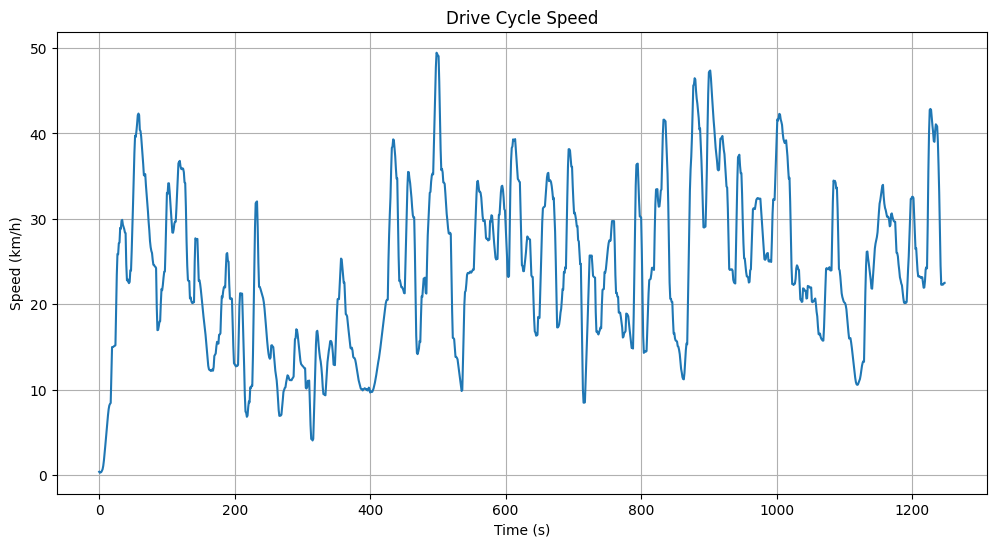

In [ ]:
# prompt: plot df['Speed [km/h]']

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Time [s]'], df['Speed [km/h]'])
plt.xlabel('Time (s)')
plt.ylabel('Speed (km/h)')
plt.title('Drive Cycle Speed')
plt.grid(True)
plt.show()


In [ ]:

def dataForce(mass,rho,Cd,Af,g,alpha,r,df):
    df['speed'] = df['Speed']
    df['distance'] = (df['speed'] * df['Time [s]'].diff()).cumsum().fillna(0)
    df['Acceleration'] = df['speed'].diff() / df['Time [s]'].diff()
    df['positiveAcceleration'] = df['Acceleration'].where(df['Acceleration'] >= 0, 0)
    df['angle'] = 0

    # Force due to acceleration
    df['Force_Acceleration'] = mass*df['positiveAcceleration']

    # Force due to drag
    df['Force_Drag'] = 0.5*rho*Af*Cd*(df['speed']**2)

    # Force due to friction
    # Since friction cofficient itself is speed dependent so first we have to calculate the friction cofficient
    df['Friction_Cofficient'] = np.where(df['Speed [km/h]'] <= 0, 0, 0.01*(1+df['Speed [km/h]']/160))
    df['Force_Rolling_Resistance'] = df['Friction_Cofficient']*mass*g*np.cos(np.radians(df['angle']))

    # Force due to its own weight travelling on a gradient
    df['Force_Weight'] = mass*np.sin(np.radians(df['angle']))

    # Total Force at all the instant points

    # Doubt for calculating the all forces We should only consider5 the forces where the acceleration is positive
    # As the vehicle is in braking mode when the acceleration is negative and battery is not providing any energy
    # Total Force at all the instant points

    df['Force_Total'] = df['Force_Weight'] + df['Force_Rolling_Resistance'] + df['Force_Drag'] + df['Force_Acceleration']

    # Force vise power analysdf_force_analysis
    df['Power_Drag'] = df['Force_Drag']*df['speed']
    df['Power_Rolling_Resistance'] = df['Force_Rolling_Resistance']*df['speed']
    df['Power_Drag'] = df['Force_Drag']*df['speed']
    df['Power_Acceleration'] = df['Force_Acceleration']*df['speed']
    df['Power_Total'] = df['Force_Total']*df['speed']


    df['omega'] = df['speed']/r
    df['omega_rpm'] = df['omega']*(60/(2*np.pi))
    df['Torque_Wheel'] = df['Force_Total']*r

    df['Power_Wheels'] = df['Torque_Wheel']*df['omega']
    return df


**Function to plot forces**

In [ ]:
def plot_motor_forces(df):
    # Plotting individual forces

    plt.plot(df['Time [s]'], df['Force_Acceleration'], label='Force Acceleration', linestyle=':')
    plt.xlabel('Time [s]')
    plt.ylabel('Force Acceleration [N]')
    plt.title('Acceleration Forces Over Time')
    plt.show()
    plt.plot(df['Time [s]'], df['Force_Drag'], label='Force Drag', linestyle=':')
    plt.xlabel('Time [s]')
    plt.ylabel('Force Drag [N]')
    plt.title('Drag Forces Over Time')
    plt.show()
    plt.plot(df['Time [s]'], df['Force_Rolling_Resistance'], label='Force Rolling Resistance', linestyle=':')
    plt.xlabel('Time [s]')
    plt.ylabel('Force Rolling resistance [N]')
    plt.title('Rolling Forces Over Time')
    plt.show()
    plt.plot(df['Time [s]'], df['Force_Weight'], label='Force Weight', linestyle=':')
    plt.xlabel('Time [s]')
    plt.ylabel('Force Weight [N]')
    plt.title('Weight Forces Over Time')
    plt.show()



    # Plotting total force
    plt.figure(figsize=(14, 6))
    plt.plot(df['Time [s]'], df['Force_Total'], color='red', label='Total Force', linestyle=':' )

    plt.xlabel('Time [s]')
    plt.ylabel('Total Force [N]')
    plt.title('Total Force Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()

**Function to plot Motor Power**

In [ ]:
def plot_motor_power(df):
    # Plotting individual forces

    plt.plot(df['Time [s]'], df['Force_Acceleration'], label='Force Acceleration', linestyle=':')
    plt.xlabel('Time [s]')
    plt.ylabel('Force Acceleration [N]')
    plt.title('Acceleration Forces Over Time')
    plt.show()
    plt.plot(df['Time [s]'], df['Force_Drag'], label='Force Drag', linestyle=':')
    plt.xlabel('Time [s]')
    plt.ylabel('Force Drag [N]')
    plt.title('Drag Forces Over Time')
    plt.show()
    plt.plot(df['Time [s]'], df['Force_Rolling_Resistance'], label='Force Rolling Resistance', linestyle=':')
    plt.xlabel('Time [s]')
    plt.ylabel('Force Rolling resistance [N]')
    plt.title('Rolling Forces Over Time')
    plt.show()
    plt.plot(df['Time [s]'], df['Force_Weight'], label='Force Weight', linestyle=':')
    plt.xlabel('Time [s]')
    plt.ylabel('Force Weight [N]')
    plt.title('Weight Forces Over Time')
    plt.show()



    # Plotting total force
    plt.figure(figsize=(14, 6))
    plt.plot(df['Time [s]'], df['Force_Total'], color='red', label='Total Force', linestyle=':' )

    plt.xlabel('Time [s]')
    plt.ylabel('Total Force [N]')
    plt.title('Total Force Over Time')
    plt.grid(True)
    plt.legend()
    plt.show

In [ ]:
mass = 260
rho = 1.22   ## Density of Air
Cd = 0.78   ## Aerodynamic Drag
Af = 0.68   ## frontal area of the vehical
g = 9.81  # graviatational coefficient
alpha=0   # Road Angle
r = 0.215  # radius of wheel in meters

df = dataForce(mass,rho,Cd,Af,g,alpha,r,df)

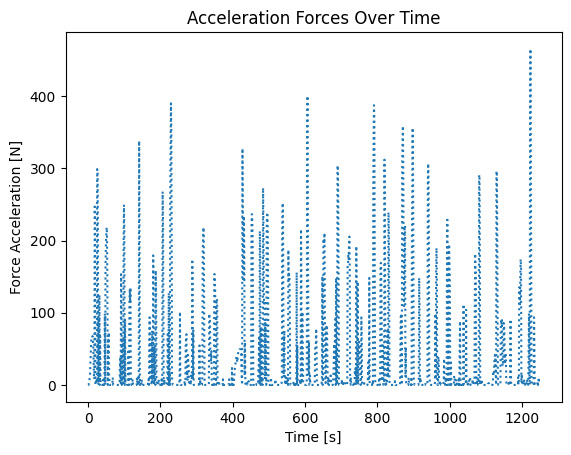

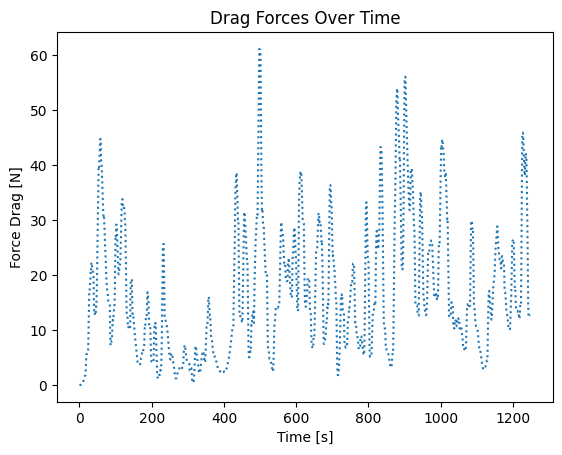

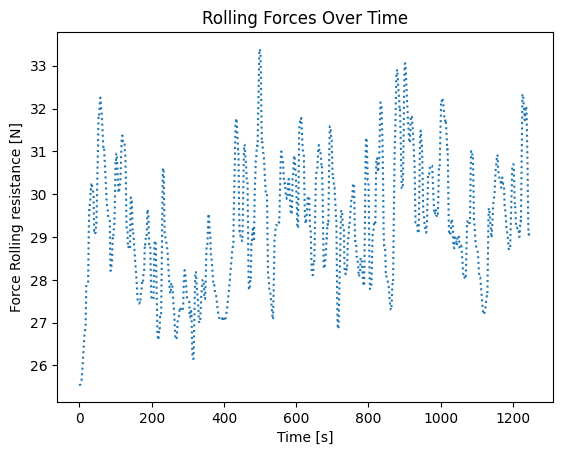

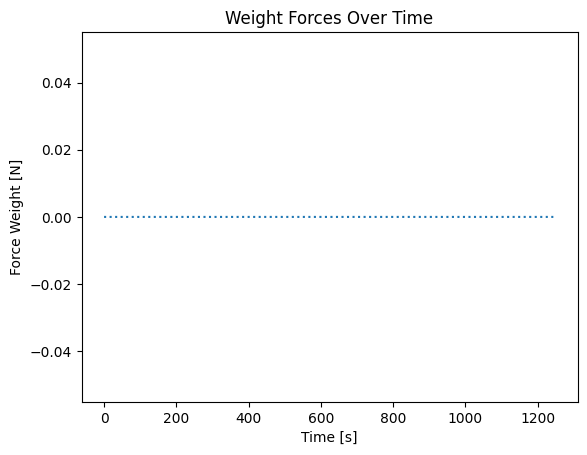

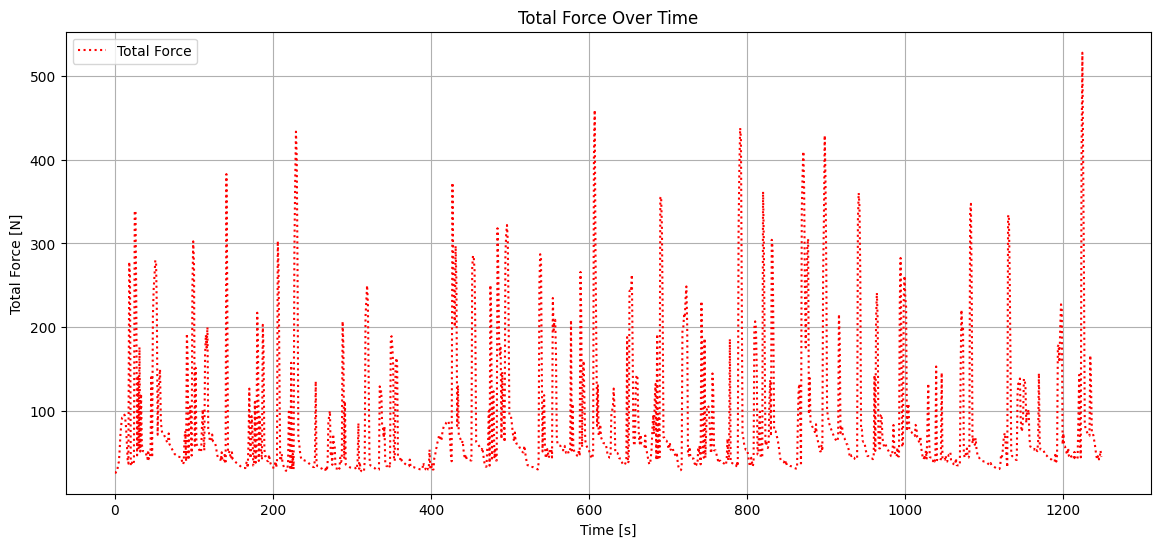

In [ ]:
plot_motor_forces(df)

In [ ]:
df.head()

Speed  Speed [km/h]  Time [s]  speed  distance  Acceleration  \
0   0.10         0.360         0   0.10      0.00           NaN   
1   0.07         0.252         1   0.07      0.07         -0.03   
2   0.08         0.288         2   0.08      0.15          0.01   
3   0.09         0.324         3   0.09      0.24          0.01   
4   0.13         0.468         4   0.13      0.37          0.04   

   positiveAcceleration  angle  Force_Acceleration  Force_Drag  ...  \
0                  0.00      0                 0.0    0.003235  ...   
1                  0.00      0                 0.0    0.001585  ...   
2                  0.01      0                 2.6    0.002071  ...   
3                  0.01      0                 2.6    0.002621  ...   
4                  0.04      0                10.4    0.005468  ...   

   Force_Weight  Force_Total  Power_Drag  Power_Rolling_Resistance  \
0           0.0    25.566624    0.000324                  2.556339   
1           0.0    25.547757    0.000111                  1.788232   
2           0.0    28.153981    0.000166                  2.044153   
3           0.0    28.160270    0.000236                  2.300188   
4           0.0    35.986073    0.000711                  3.325479   

   Power_Acceleration  Power_Total     omega  omega_rpm  Torque_Wheel  \
0               0.000     2.556662  0.465116   4.441533      5.496824   
1               0.000     1.788343  0.325581   3.109073      5.492768   
2               0.208     2.252319  0.372093   3.553227      6.053106   
3               0.234     2.534424  0.418605   3.997380      6.054458   
4               1.352     4.678189  0.604651   5.773993      7.737006   

   Power_Wheels  
0      2.556662  
1      1.788343  
2      2.252319  
3      2.534424  
4      4.678189  

[5 rows x 22 columns]

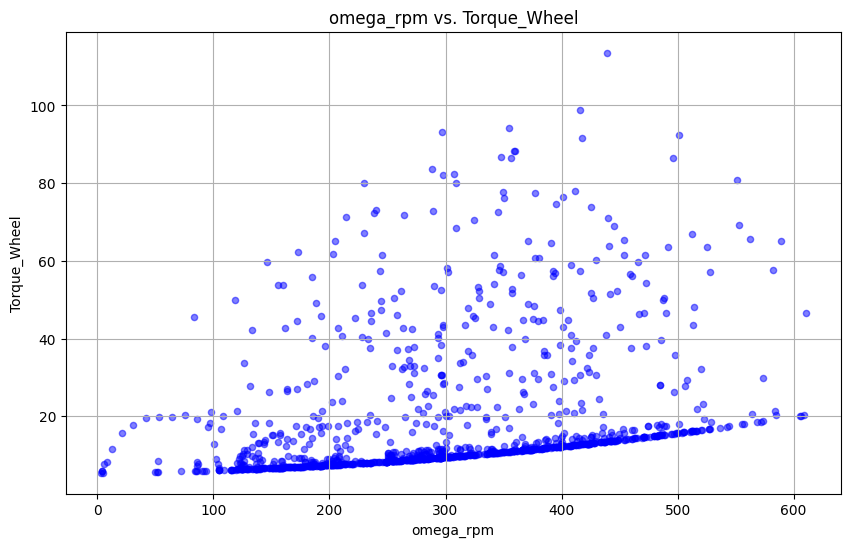

In [ ]:

plt.figure(figsize=(10, 6))
plt.scatter(df['omega_rpm'], df['Torque_Wheel'], s=20, c='blue', alpha=0.5)
plt.xlabel('omega_rpm')
plt.ylabel('Torque_Wheel')
plt.title('omega_rpm vs. Torque_Wheel')
plt.grid(True)
plt.show()


In [ ]:
# Reading the first fiile

# Read data from an Excel file into a DataFrame, setting the first column as the index
df_72s64p_full = pd.read_excel("check_1.xlsx", index_col=0)  # 72s64p

# Reverse the DataFrame along the index axis (reverse rows)
df_72s64p_full = df_72s64p_full.iloc[::-1]

# Extract torque values from the index of the DataFrame
torque_values_72s64p_full = df_72s64p_full.index.values

# Extract speed values from the columns of the DataFrame
speed_values_72s64p_full = df_72s64p_full.columns.values

FileNotFoundError: [Errno 2] No such file or directory: 'check_1.xlsx'

In [ ]:
# Create a 2D interpolation function using RectBivariateSpline for the given torque, speed, and efficiency data
interpolation_function_72s64p_full = RectBivariateSpline(torque_values_72s64p_full, speed_values_72s64p_full, df_72s64p_full.values)

# Define the range of speed and torque values
speed_values = range(901)
torque_values = range(201)

# Create an empty DataFrame with speed as index and torque as columns for interpolated data
df_72s64p_full_inter = pd.DataFrame(index=speed_values, columns=torque_values)

# Motor parameters
rated_speed = 200  # RPM
max_speed = 900  # RPM
max_torque = 190  # Nm

# Iterate over each combination of speed and torque
for s in speed_values:
    for t in torque_values:
        # Compute the efficiency using the interpolation function
        efficiency = interpolation_function_72s64p_full(t, s)
        # Fill the DataFrame with the computed efficiency
        if s < rated_speed:
            if t < max_torque:
                df_72s64p_full_inter.at[s, t] = efficiency[0][0]
            else:
                df_72s64p_full_inter.at[s, t] = np.nan
        else:
            if t < (rated_speed / s) * max_torque:
                df_72s64p_full_inter.at[s, t] = efficiency[0][0]
            else:
                df_72s64p_full_inter.at[s, t] = np.nan

In [ ]:
# Create a meshgrid of torque and speed values using np.meshgrid
Torque, Speed = np.meshgrid(torque_values, speed_values)

# Convert the DataFrame values to numeric type, handling errors by coercing invalid values to NaN
numeric_data = pd.to_numeric(df_72s64p_full_inter.values.flatten(), errors='coerce').reshape(df_72s64p_full_inter.shape)

# Create a filled contour plot using meshgrid data and efficiency values from the DataFrame, with colormap 'viridis' and 20 levels
contour = plt.contourf(Speed, Torque, numeric_data, cmap='viridis', levels=20)

# Add a color bar to the plot with label 'Efficiency'
cbar = plt.colorbar(contour, label='Efficiency')
cbar.ax.tick_params(labelsize=12)  # Adjust color bar font size

# Add contour lines with values
contour_lines = plt.contour(Speed, Torque, numeric_data, colors='black', levels=50, linewidths=0.1)
# Label contour lines with their values, specifying levels for labeling
plt.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.0f', levels=[
           50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92])

# Set x-axis label with adjusted font size
plt.xlabel('Speed (rpm)', fontsize=14)
# Set y-axis label with adjusted font size
plt.ylabel('Torque (Nm)', fontsize=14)
# Set title of the plot with adjusted font size
plt.title('Efficiency_72s64p', fontsize=16)
# Adjust x-axis tick font size
plt.xticks(fontsize=12)
# Adjust y-axis tick font size
plt.yticks(fontsize=12)
# Add grid lines with transparency
plt.grid(True, linestyle='--', alpha=0.7)
# Adjust layout for better spacing
plt.tight_layout()
# Display the plot
plt.show()

In [ ]:

# Assuming the necessary data (torque_values, speed_values, df_72s64p_full_inter, df, etc.) is already defined

# Create meshgrid for Torque and Speed values
Torque, Speed = np.meshgrid(torque_values, speed_values)

# Convert the DataFrame values to numeric type, handling errors by coercing invalid values to NaN
numeric_data = pd.to_numeric(df_72s64p_full_inter.values.flatten(), errors='coerce').reshape(df_72s64p_full_inter.shape)

# Create the figure and the axis
fig, ax = plt.subplots(figsize=(10, 8))

# Plot 1: Filled contour plot (Efficiency map)
contour = ax.contourf(Speed, Torque, numeric_data, cmap='viridis', levels=20)
# Add colorbar
cbar = fig.colorbar(contour, ax=ax, label='Efficiency')
cbar.ax.tick_params(labelsize=12)

# Add contour lines with values
contour_lines = ax.contour(Speed, Torque, numeric_data, colors='black', levels=50, linewidths=0.1)
ax.clabel(contour_lines, inline=True, fontsize=6, fmt='%1.0f', levels=[
           50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92])

# Set x and y-axis labels for the contour plot
ax.set_xlabel('Speed (RPM)', fontsize=14)
ax.set_ylabel('Torque (Nm)', fontsize=14)
ax.set_title('Efficiency Contour Plot SEG Motor', fontsize=16)

# Plot 2: Scatter plot for RPM vs Torque
# Filter out points where torque is 0
df['Torque_Wheel'] = df['Torque_Wheel'].apply(lambda x: max(x, 0))
filtered_df = df[df['Torque_Wheel'] != 0]
filtered_df['RPM'] = filtered_df['omega_rpm']

# Calculate the average RPM and Torque
avg_rpm = filtered_df['RPM'].mean()
avg_torque = filtered_df['Torque_Wheel'].mean()

rpm = np.linspace(0, 900, 10)  # Define the range for RPM
max_torque = 190  # Nm
rated_speed = 200  # rpm
max_power = 3980  # W
torque = []

for speed in rpm:
    if speed <= rated_speed:
        torque.append(max_torque)
    elif speed > rated_speed and speed <= 300 :
        torque.append(4200 / (speed * (2 * np.pi / 60)))
    elif speed > 300 and speed <= 400 :
        torque.append(4300 / (speed * (2 * np.pi / 60)))
    elif speed > 400 and speed <= 500 :
        torque.append(4400 / (speed * (2 * np.pi / 60)))
    else :
        torque.append(4500 / (speed * (2 * np.pi / 60)))




# Scatter plot for RPM vs Torque
scatter = ax.scatter(
    filtered_df['RPM'],
    filtered_df['Torque_Wheel'],
    cmap='viridis', s=40, edgecolor='k', alpha=0.4
)
# Scatter plot for average RPM and Torque
ax.scatter(avg_rpm, avg_torque, color='blue', s=100, label=f'Avg RPM = {avg_rpm:.2f}\nAvg Torque = {avg_torque:.2f}')

# Plot the Torque curve
ax.plot(rpm, torque, label='Torque Curve', color='blue', linewidth=2)



# Add legend, grid, and adjust ticks
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', labelsize=12)

# Adjust layout for a cleaner look
plt.tight_layout()

# Show the final overlapped plot
plt.show()


In [ ]:
rpm = np.linspace(0, 900, 10)  # Define the range for RPM
max_torque = 190  # Nm
rated_speed = 200  # rpm
max_power = 3980  # W
torque = []

for speed in rpm:
    if speed <= rated_speed:
        torque.append(max_torque)
    elif speed > rated_speed and speed < 300 :
        torque.append(4200 / (speed * (2 * np.pi / 60)))
    elif speed > 300 and speed < 400 :
        torque.append(4300 / (speed * (2 * np.pi / 60)))
    elif speed > 400 and speed < 500 :
        torque.append(4400 / (speed * (2 * np.pi / 60)))
    else :
        torque.append(4500 / (speed * (2 * np.pi / 60)))

plt.plot(rpm, torque)

In [ ]:
def modeDiff(observed_data,candidate_cycle,mode_cycle) :

    value_counts_dc = Counter(mode_cycle)

    for s in value_counts_dc:
            value_counts_dc[s] = value_counts_dc[s]/len(mode_cycle)


    od_list = observed_data["mode"].tolist()
    value_counts_od = Counter(od_list)

    for s in value_counts_od:
            value_counts_od[s] = value_counts_od[s]/len(od_list)

    add = 0

    for s in value_counts_od:

        add+=abs(value_counts_od[s]-value_counts_dc[s])
    return add

In [ ]:
modeDiff_val = []
for i in range(len(candidateDriveCycles)) :
    out = modeDiff(df_all,candidateDriveCycles[i],modeDriveCycles[i])
    modeDiff_val.append(out)

In [ ]:

plt.hist(modeDiff_val, bins=20, edgecolor='black')
plt.title('Histogram of SAFD Diff Values')
plt.xlabel('Mode Diff')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
import heapq

# Find the indices of the five smallest values in SAFDiff_val
smallest_indices = heapq.nsmallest(5, range(len(SAFDiff_val)), key=modeDiff_val.__getitem__)

print(smallest_indices)


In [ ]:
for i in smallest_indices :
    print(modeDiff_val[i])
    print("Average Speed : ",np.average(candidateDriveCycles[i]))
    print("Standard deviation of speed",np.std(candidateDriveCycles[i]))
    drive_cycle_acceleration = np.diff(candidateDriveCycles[i])
    avg_acceleration = np.mean(drive_cycle_acceleration)
    std_acceleration = np.std(drive_cycle_acceleration)
    print(f"Average Acceleration: {avg_acceleration}")
    print(f"Standard Deviation of Acceleration: {std_acceleration}")
    plt.plot(candidateDriveCycles[i])
    plt.show()

In [ ]:

# Target parameters
target_avg_speed = 7.550182517436934
target_std_speed = 3.0511792122892034
target_avg_acc = 7.56143667296787e-05
target_std_acc = 0.5231210422099255

def calculate_error(candidate):
    speed = np.array(candidate)

    # Calculate acceleration as the difference in consecutive speed values
    acc = np.diff(speed)

    # Calculate statistics
    avg_speed = np.mean(speed)
    std_speed = np.std(speed)
    avg_acc = np.mean(acc)
    std_acc = np.std(acc)

    # Calculate individual errors
    speed_mean_error = abs((avg_speed - target_avg_speed))
    speed_std_error = abs((std_speed - target_std_speed) )
    acc_mean_error = abs((avg_acc - target_avg_acc) )
    acc_std_error = abs((std_acc - target_std_acc))

    # Total error (you can adjust weights here if needed)
    total_error = speed_mean_error + speed_std_error + acc_mean_error + acc_std_error

    return total_error
error_list = []
for i in candidateDriveCycles:
    error = calculate_error(i)
    error_list.append(error)
# Output the best cycle and its error
best_cycle_index = np.argmin(error_list)
best_cycle = candidateDriveCycles[best_cycle_index]
best_cycle_error = error_list[best_cycle_index]
print("Best Drive Cycle:", best_cycle)
plt.plot(best_cycle)
plt.show()
print("Total Error for Best Drive Cycle:", best_cycle_error)


In [ ]:
i = best_cycle_index
print("Average Speed : ",np.average(candidateDriveCycles[i]))
print("Standard deviation of speed",np.std(candidateDriveCycles[i]))
drive_cycle_acceleration = np.diff(candidateDriveCycles[i])
avg_acceleration = np.mean(drive_cycle_acceleration)
std_acceleration = np.std(drive_cycle_acceleration)
print(f"Average Acceleration: {avg_acceleration}")
print(f"Standard Deviation of Acceleration: {std_acceleration}")
plt.plot(candidateDriveCycles[i])
plt.show()